In [1]:
import requests
import pandas as pd
import json
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt
import numpy as np
%matplotlib inline
#plt.style.use('Solarize_Light2')
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import warnings
warnings.filterwarnings("ignore") # specify to ignore warning messages
#from pandas.plotting import register_matplotlib_converters
#register_matplotlib_converters()


In [2]:
cov = pd.read_csv('new_datav4.csv')
cov1 = pd.read_csv('new_datav4.csv',index_col=1)
cov=cov.drop(['Unnamed: 0'],axis=1)
y=cov['Senegal']
data_sn1=cov['Senegal'][36:]
data_sn1=data_sn1.reset_index()
data_sn1=data_sn1.drop(['index'],axis=1)
y1=data_sn1

# Exploration des données

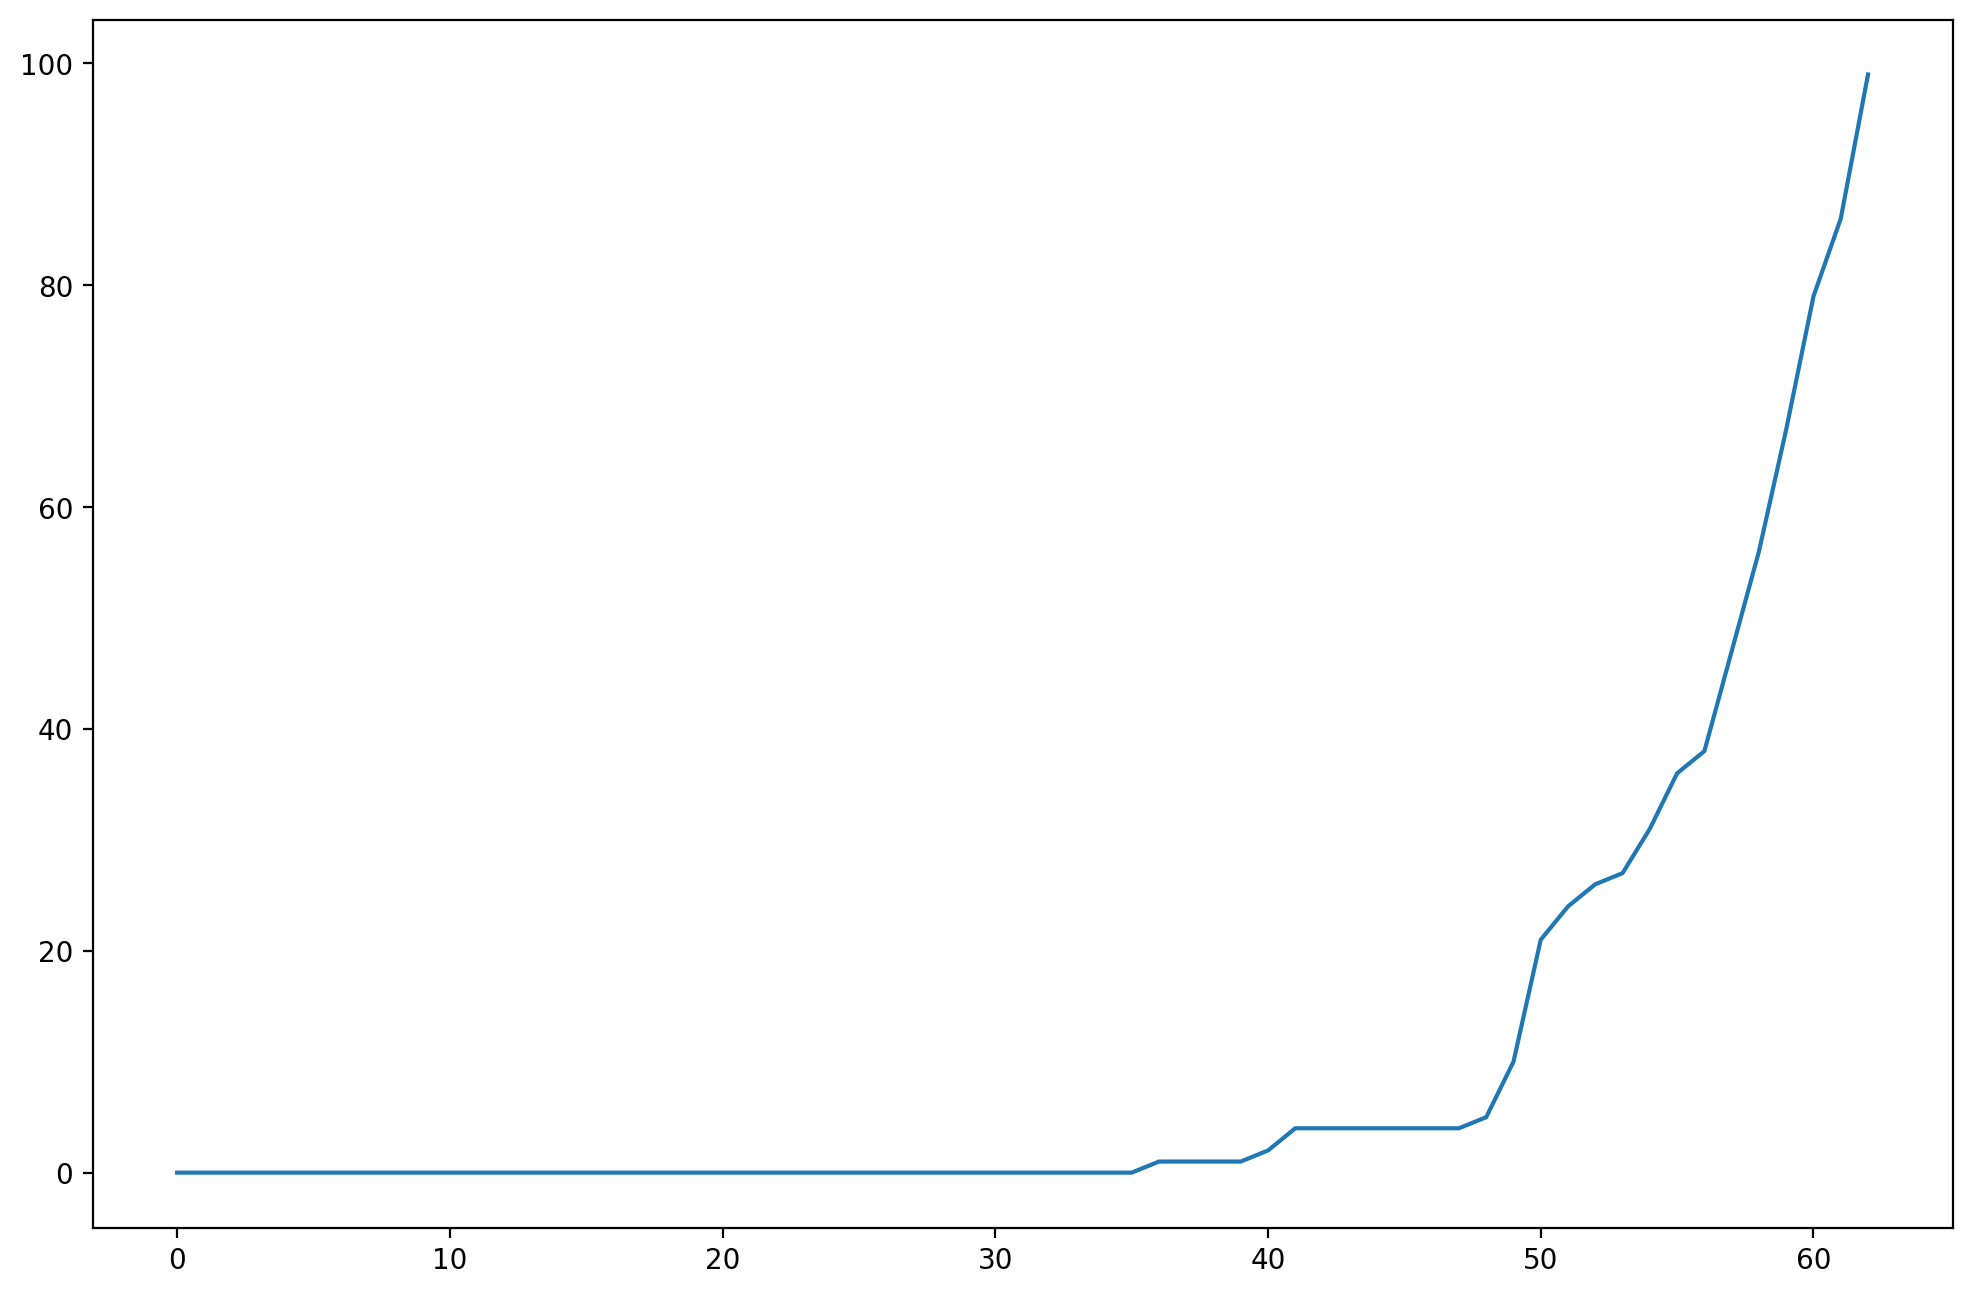

In [4]:
plt.figure(figsize=(12,8),dpi=200)
plt.plot(cov['Senegal'], label="Cases")
plt.show ()


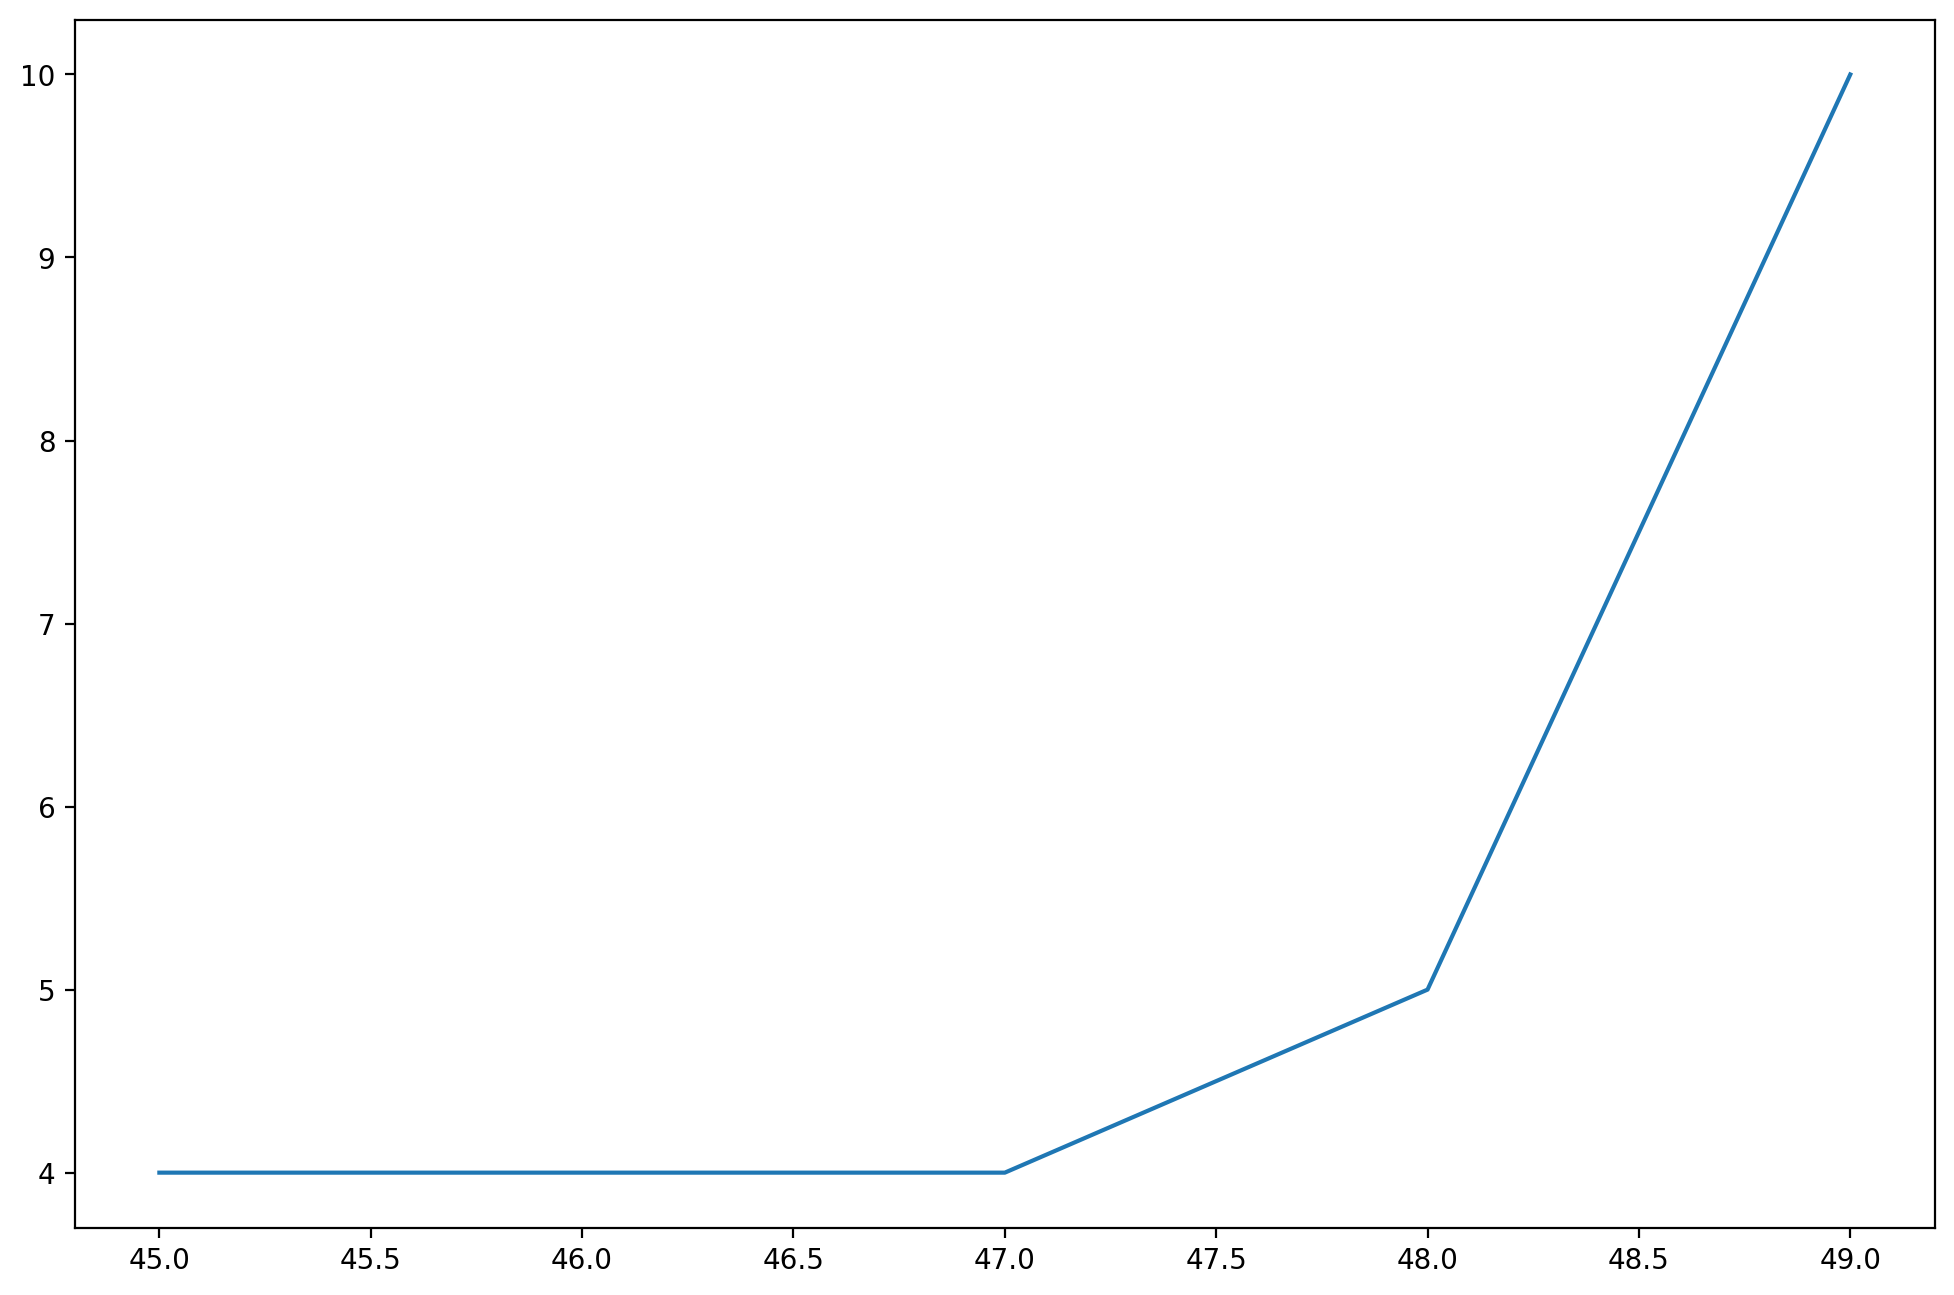

In [5]:
plt.figure(figsize=(12,8),dpi=200)
plt.plot(cov['Senegal'][45:50], label="Cases")
plt.show ()

# #Auto-correlation and Partial Auto-correlation
Une autocorrélation partielle (PACF) graphique représente la quantité de corrélation entre une série et un décalage de lui-même qui ne sont pas expliquée par les corrélations à tous les bas - décalages de commande.
Idéalement, nous ne voulons aucune corrélation entre la série et les décalages d'elle-même. Graphiquement parlant, nous aimerions que tous les pics tombent dans la région bleue.

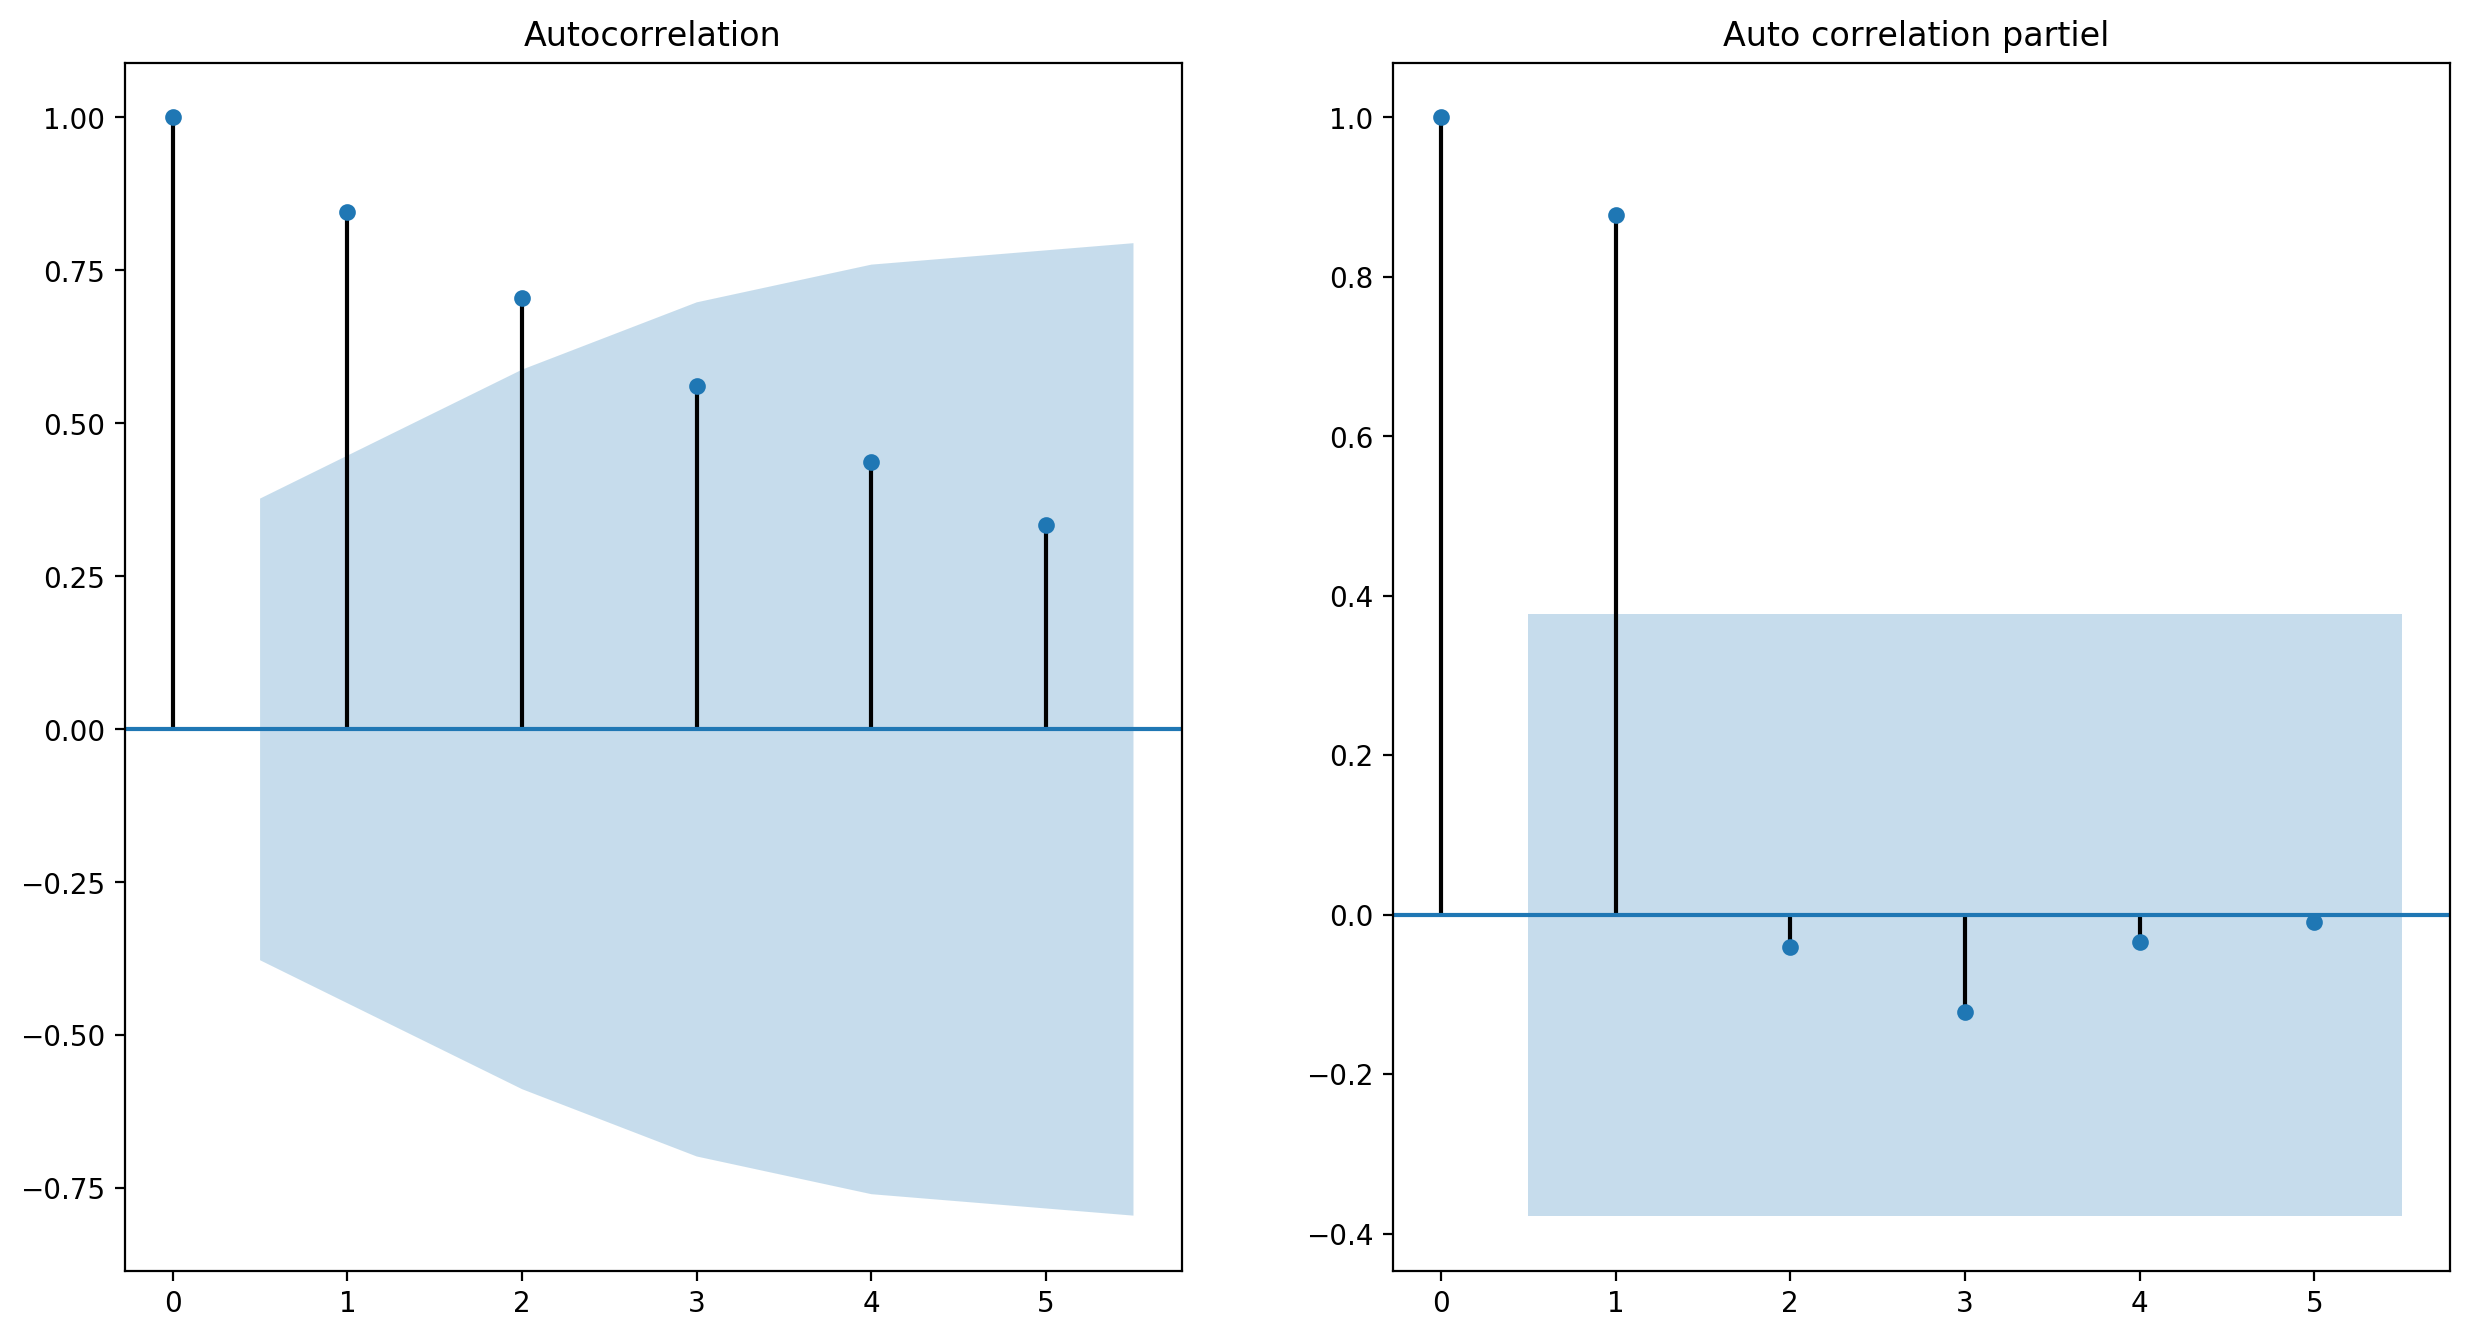

In [6]:
# Auto correlation pariel
import statsmodels.api as sm

fig, axes = plt.subplots(1, 2, figsize=(15,8),dpi=200)

fig = sm.graphics.tsa.plot_acf(y1, lags=5, ax=axes[0])
fig = sm.graphics.tsa.plot_pacf(y1, lags=5, ax=axes[1])
plt.title("Auto correlation partiel ")
plt.savefig("Auto correlation partiel  ")
plt.show()

**Comme nous pouvons le voir, il existe plusieurs pointes au-dessus de la région bleue, ce qui signifie qu'il existe des corrélations aux décalages 1 et 2 ** 


# #Test de stationnarité
**Test Dickey-Fuller amélioré** 

Ce test est utilisé pour évaluer si une série chronologique est stationnaire ou non. Sans entrer dans trop de détails sur le test d'hypothèse, vous devez savoir que ce test donnera un résultat appelé «test-statistique», sur la base duquel vous pouvez dire, avec différents niveaux (ou pourcentage) de confiance, si la série chronologique est stationnaire ou non.


In [7]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(y1)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: 3.272128
p-value: 1.000000
Critical Values:
	1%: -3.809
	5%: -3.022
	10%: -2.651


Le test montre que:

**1%: --3.738 data_sn** n'est pas staionnaire avec un intervalle de confiance à 99%   

**5%: -2.992** data_sn n'est pas staionnaire avec un intervalle de confiance à 95% 

**10%: -2.636** data_sn n'est pas staionnaire avec un intervalle de confiance à 90% 

Donc on peut conclure que notre jeu de donnees n'est pas stationaire

# Decomposition Automatique de la serie data_sn
Chaque série chronologique peut être pensée comme un mélange de plusieurs parties:

Une **tendance** (mouvement à la hausse ou à la baisse de la courbe sur le long terme)

Une **composante saisonnière**

**Résidus**

Voici à quoi ressemble notre série chronologique lorsqu'elle est divisée en les composants ci-dessus:

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(y1, freq=1, extrapolate_trend='freq')
print(decomposition)

<Figure size 12600x9800 with 0 Axes>

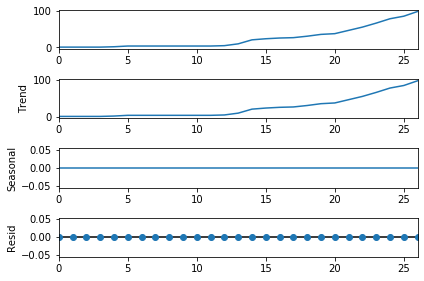

In [9]:
plt.figure(figsize=(18,14),dpi=700)
decomposition.plot()
#plt.title("Decomposition auomaique de la séerie temporelle data_sn")
#plt.savefig("Decomposition auomaique de la séerie data_sn ")
plt.show()

Notre série chronologique montre une nette tendance à la hausse. Cependant elle ne semble pas etre saisonnière
 La variance des résidus semble constante avec le temps, 

## Choix du Modèle

Puisque  les méthodes de lissage  sont appropriées pour les données non stationnaires et peut nombreuses,
dans cette étude  nous utiliserons le **lissage exponenielle simple** et lissage par  **la méthodes de Holt**
(c'est-à-dire les données avec une tendance et les données saisonnières).


# #Lissage Exponentielle Simple

Il n'a qu'un seul composant appelé niveau avec un paramètre de lissage noté «alpha» . Il s'agit d'une moyenne pondérée du niveau précédent et de l'observation actuelle:

Les méthodes de lissage exponentiel attribuent des poids décroissants de façon 
 exponentielle aux observations passées. Plus l'observation est récente, plus le poids sera élevé. Par exemple, il est raisonnable d'attribuer des poids plus importants aux observations d'hier qu'aux observations faites il y a 7 jour
 **Formulation Mathélatique**
 
 $y_{t+1}=\alpha*y_t +\alpha(1-\alpha)y_{t-1}+\alpha(1-\alpha)^{2}y_{t-2}+\alpha(1-\alpha)^{3}y_{t-3}+...$
 
 ou $0\leq \alpha \leq 1$ est le paramètre de lissage
 
 Le taux de diminution des poids est contrôlé par le paramètre de lissage α. Si α est grand (c.-à-d. Près de 1), plus de poids est accordé aux observations les plus récentes. Il y a 2 cas extrêmes:
 
$\alpha =0$: les prévisions de toutes les valeurs futures sont égales à la moyenne (ou «moyenne») des données historiques, qui est appelée méthode Moyenne .

$\alpha =0$: définissez simplement toutes les prévisions sur la valeur de la dernière observation, appelée méthode naïve en statistique.

## recherche de la meilleur valeur du paramètre alpha
Pour trouver la meilleur valeur de alpha c'est à dire celle qui donne la meilleur prediction (avec le plus petit MSE) nous 

essayons tous le valeurs comprises entre 0 et 1 avec un pas de 0.1

In [10]:
#Etant données que entre le 22-01-2020 et le 2020-02-27 nous utiliserons les données enrregoistrées  apartir du 2020-02-28
#Extraction du jeu de données de travail
data_sn=cov1['Senegal']

In [11]:
from sklearn.metrics import mean_squared_error
value_poss=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
mse_list=[]
params=[]
for i in value_poss:
        fit = SimpleExpSmoothing(data_sn1).fit(smoothing_level=i)
        predicted=fit.fittedvalues
        error = mean_squared_error(data_sn1, predicted)
        mse_list.append(error)
        params.append(i)
ind=mse_list.index(min(mse_list))
#print(mse_list[ind],params[ind])
print('Le MSE minimal est {0} et la valeur de alpha correspondante est {1}'.format(mse_list[ind],params[ind]))

Le MSE minimal est 37.22405281912739 et la valeur de alpha correspondante est 0.9


**La valeur de alpha avec le plus petit MSE est égale à 0.9**

Ainsi nous écrivons notre modèle de prédiction de lissage exponentiel simple avec un $\alpha=0.9$

## Prédiction avec le lissage exponentiel simple pour $\alpha=0.9$

In [12]:
# Nous utilisons l'optimisation automatique qui permet à statsmodels de trouver automatiquement une valeur optimisée de alpha pour nous. 
# Simple Exponential Smoothing
# Simple Exponential Smoothing

fit = SimpleExpSmoothing(data_sn1).fit(smoothing_level=0.9)
predicted=fit.fittedvalues
error = mean_squared_error(data_sn1, predicted)
print( 'Le MSE est {}'.format(error))

Le MSE est 37.22405281912739


**Visualisation des résultas**

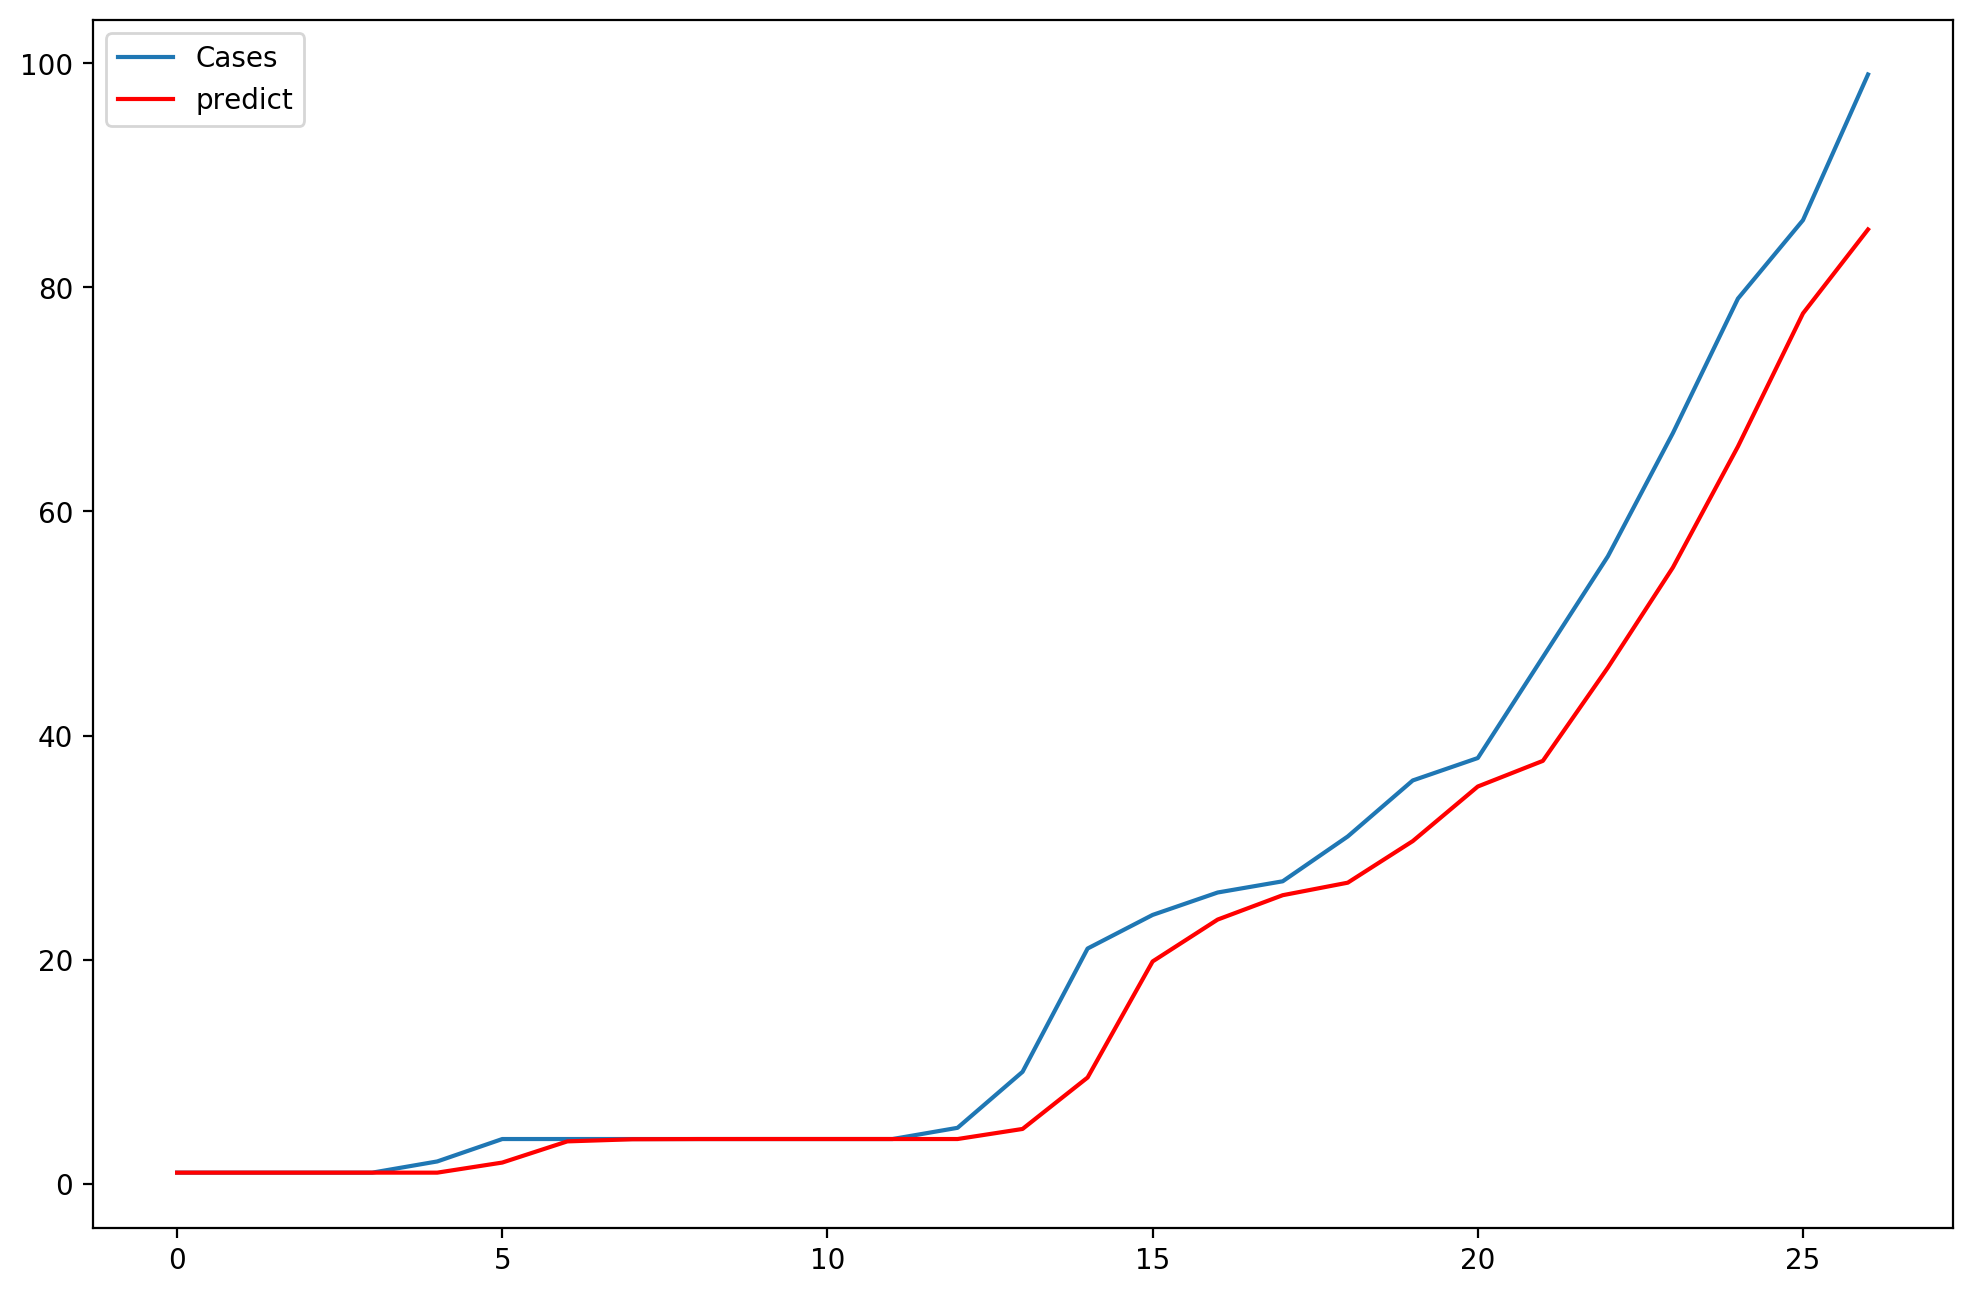

In [13]:
# plot
plt.figure(figsize=(12,8),dpi=200)
plt.plot(data_sn1, label="Cases") # la courbe des données réelles 
plt.plot(fit.fittedvalues, label="predict",color='red')# la courbe des données prédites
plt.legend()
plt.show ()

## Prédiction pour les 5 prochains jours

In [14]:
fcast = fit.forecast(5)
fcast

27    97.616801
28    97.616801
29    97.616801
30    97.616801
31    97.616801
dtype: float64

# Lissage de par la methode de Holt
Holt a fait une extention du lissage exponentiel simple  pour permettre la prévision des données avec des tendances.

La méthode de Holt implique une équation de prévision et deux équations de lissage

**Formulation Mathématiques**

prediction:   $y_{t+h=l_t+hb_t}$

Niveau de lissage:  $l_{t}=\alpha*y_t +(1-\alpha)(l_{t-1}+b_{b_-1}$

Tendace: $b_t=\beta(l_t-l_{t-1})+(1-\beta)b_{t-1} $

0≤ α ≤1 est le paramètre de lissage exponenielle

 0≤ β  ≤1 est le paramètre de lissage de la tendance.

## Lissage de par la methode de Holt avec Tendance lineaire

Le MSE minimal est 8.751198859724095 et la valeur de alpha et beta correspondantes sont (0.9, 0.7)
Le MSE est 8.912149519094058


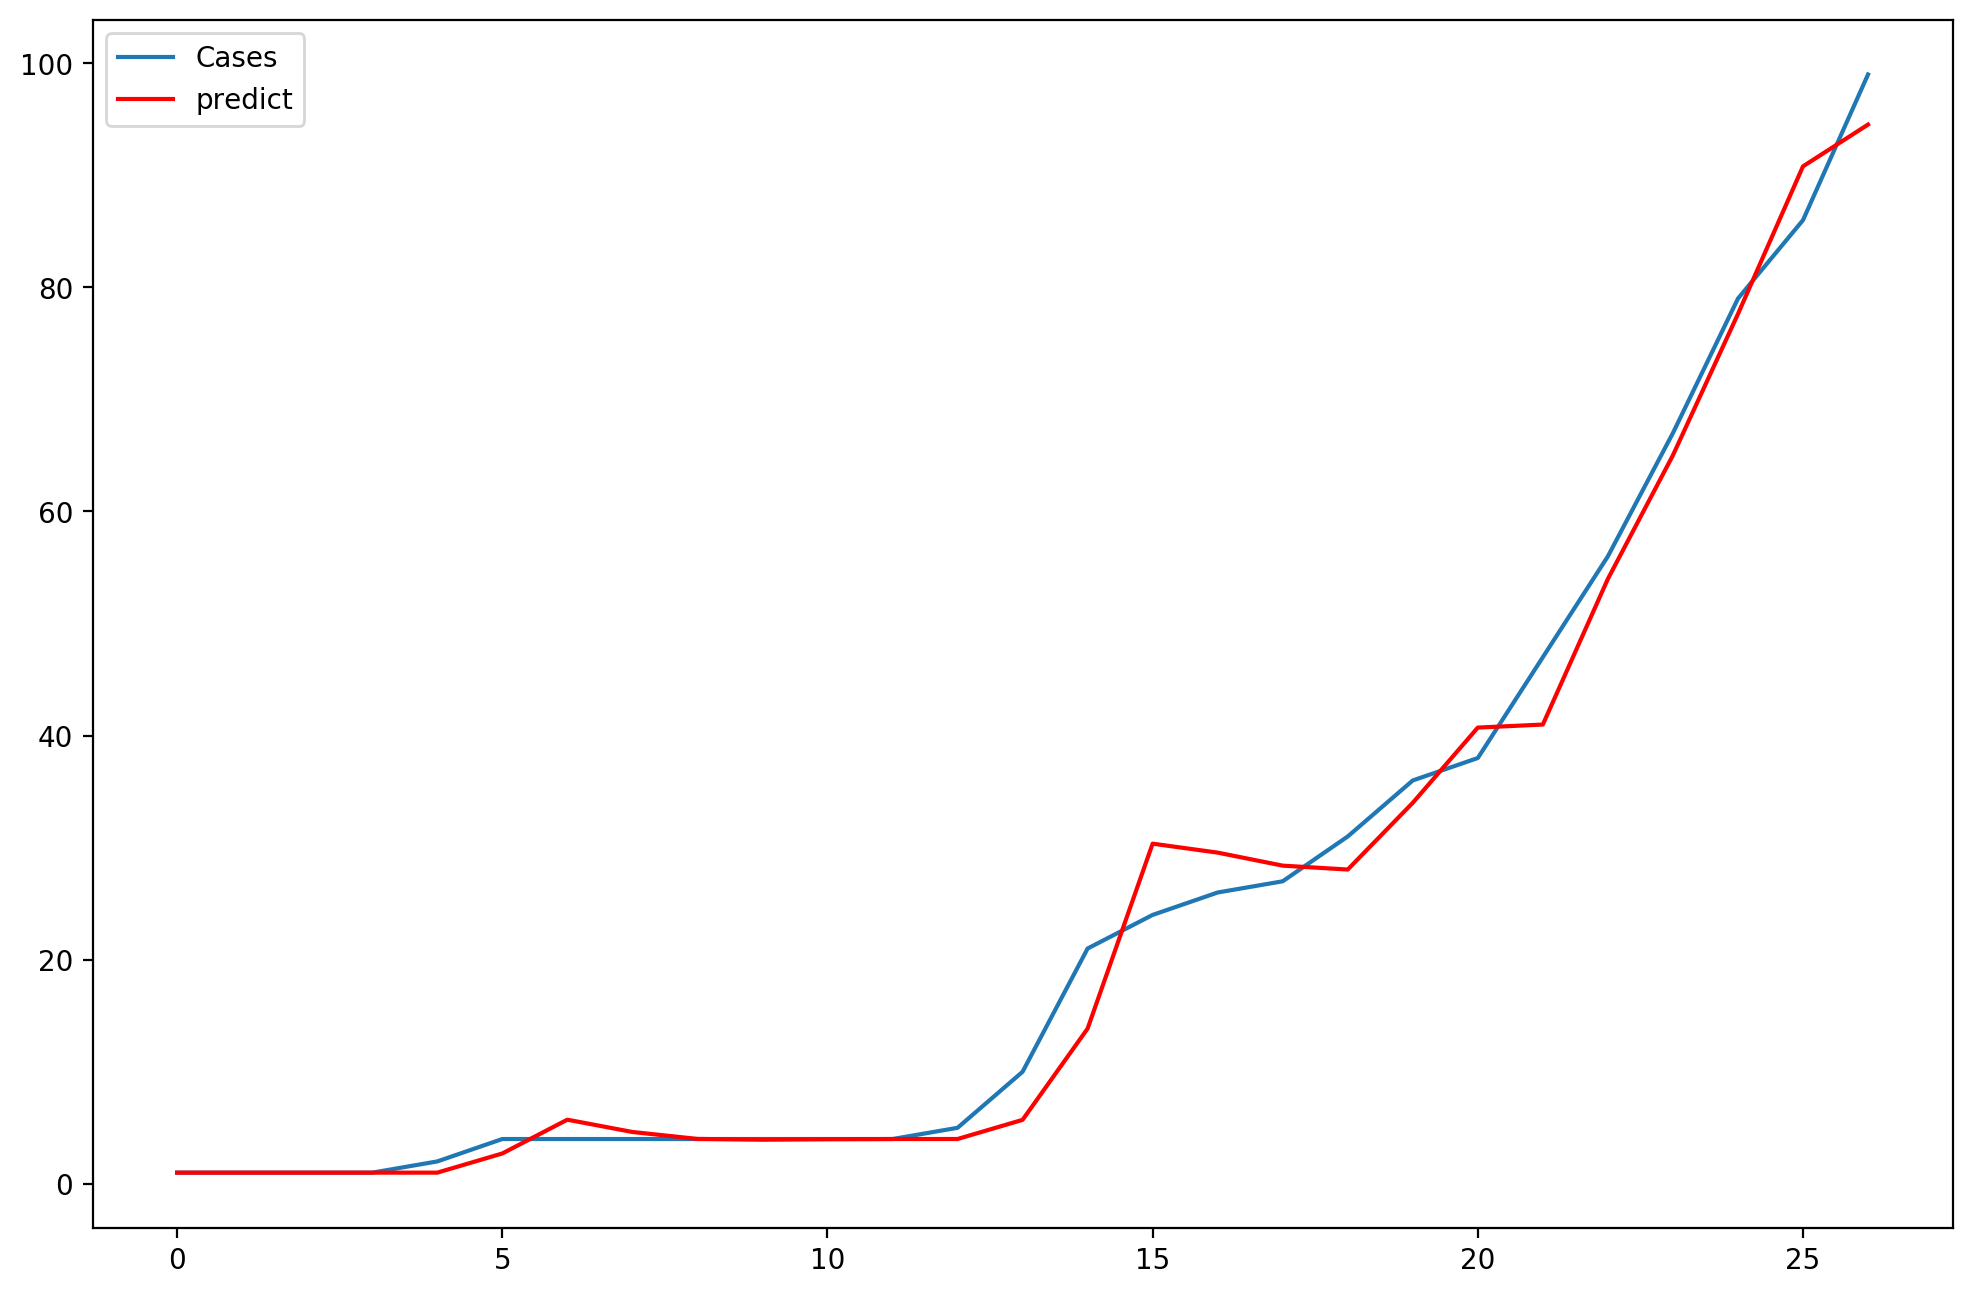

Les prévisions pour les 5 prochains jours sont:
27    110.223514
28    121.894094
29    133.564673
30    145.235252
31    156.905831
Name: Holt's linear trend, dtype: float64 


In [15]:
#Recherche des meilleurs valeurs des paramètres alpha et beta
#Pour trouver la meilleur valeur de alpha et de beta avec le plus petit MSE nous  essayons tous 
#le valeurs comprises entre 0 et 1 avec un pas de 0.1

value_poss=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
from sklearn.metrics import mean_squared_error
mse_list=[]
params=[]
for i in value_poss:
    for j in value_poss:
        fit1=Holt(data_sn1).fit(smoothing_level=i, smoothing_slope=j, optimized=False)
        predicted=fit1.fittedvalues
        error = mean_squared_error(data_sn1, predicted)
        mse_list.append(error)
        params.append((i,j))
ind=mse_list.index(min(mse_list))
#print(mse_list[ind],params[ind])
print('Le MSE minimal est {0} et la valeur de alpha et beta correspondantes sont {1}'.format(mse_list[ind],params[ind]))

# Prédiction avec la methode de Holt  pour  𝛼=0.9 et  β=0.9 
fit1=Holt(data_sn1).fit(smoothing_level=params[ind][0], smoothing_slope=params[ind][0], optimized=False)
predicted=fit1.fittedvalues
error = mean_squared_error(data_sn1, predicted)
print( 'Le MSE est {}'.format(error))


# Visualisation de la prévision
plt.figure(figsize=(12,8),dpi=200)
plt.plot(data_sn1, label="Cases") # la courbe des données réelles 
plt.plot(fit1.fittedvalues, label="predict",color='red')# la courbe des données prédites
plt.legend()
plt.show ()

## Prédiction pour les 5 prochains jours
fcast1 = fit1.forecast(5).rename("Holt's linear trend")
print( 'Les prévisions pour les 5 prochains jours sont:')
      
print('{} '.format(fcast1))




## Lissage de par la methode de Holt avec Tendance exponentielle

Le MSE minimal est 12.874757675968262 et la valeur de alpha et beta correspondantes sont (0.9, 0.1)
Le MSE est 24.54283232056546


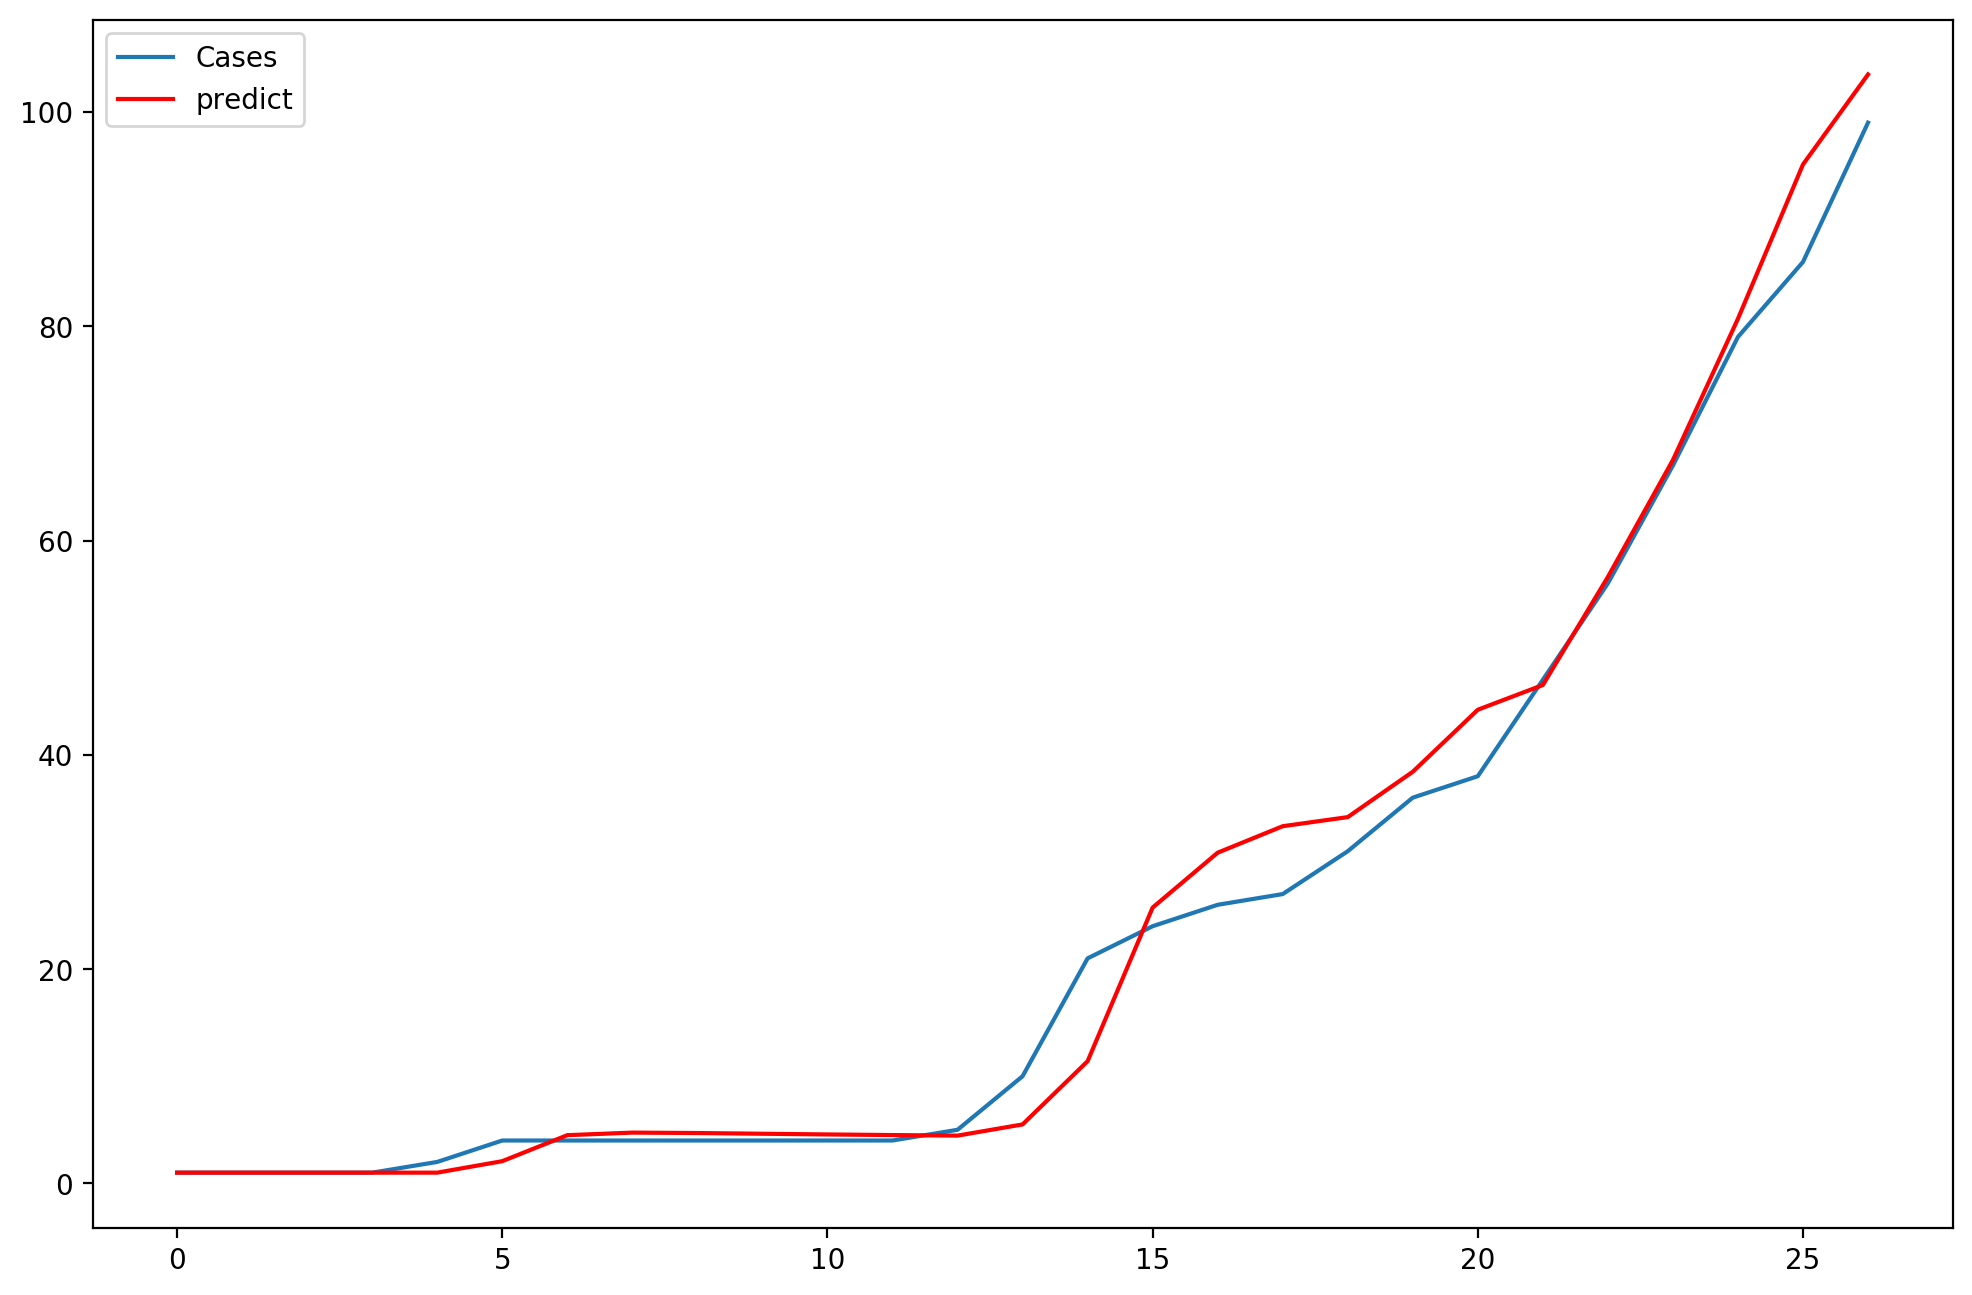

Les prévisions pour les 5 prochains jours sont:
27    117.967403
28    139.933087
29    165.988809
30    196.896141
31    233.558457
Name: Exponential trend, dtype: float64 


In [16]:
data_sn1=cov['Senegal'][36:]
data_sn1=data_sn1.reset_index()
data_sn1=data_sn1.drop(['index'],axis=1)


value_poss=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
from sklearn.metrics import mean_squared_error
mse_list=[]
params=[]
for i in value_poss:
    for j in value_poss:
        fit2 = Holt(data_sn1, exponential=True).fit(smoothing_level=i, smoothing_slope=j, optimized=False)
        #fcast2 = fit2.forecast(5).rename("Exponential trend")
        predicted=fit2.fittedvalues
        error = mean_squared_error(data_sn1, predicted)
        mse_list.append(error)
        params.append((i,j))
ind=mse_list.index(min(mse_list))
#print(mse_list[ind],params[ind])
print('Le MSE minimal est {0} et la valeur de alpha et beta correspondantes sont {1}'.format(mse_list[ind],params[ind]))


fit2 = Holt(data_sn1, exponential=True).fit(smoothing_level=params[ind][0], smoothing_slope=params[ind][1], optimized=False)
fcast2= fit2.forecast(5).rename("Exponential trend")
error = mean_squared_error(data_sn1, predicted)
print( 'Le MSE est {}'.format(error))

# Visualisation de la prévision
plt.figure(figsize=(12,8),dpi=200)
plt.plot(data_sn1, label="Cases") # la courbe des données réelles 
plt.plot(fit2.fittedvalues, label="predict",color='red')# la courbe des données prédites
plt.legend()
plt.show ()

fcast2 = fit2.forecast(5).rename("Exponential trend")
print( 'Les prévisions pour les 5 prochains jours sont:')
      
print('{} '.format(fcast2))


## Lissage de par la methode de Holt avec Tendance linèaire ajustée 

Le MSE minimal est 8.751190061279294 et la valeur de alpha et beta correspondantes sont (0.9, 0.7)
Le MSE est 8.901042177159983


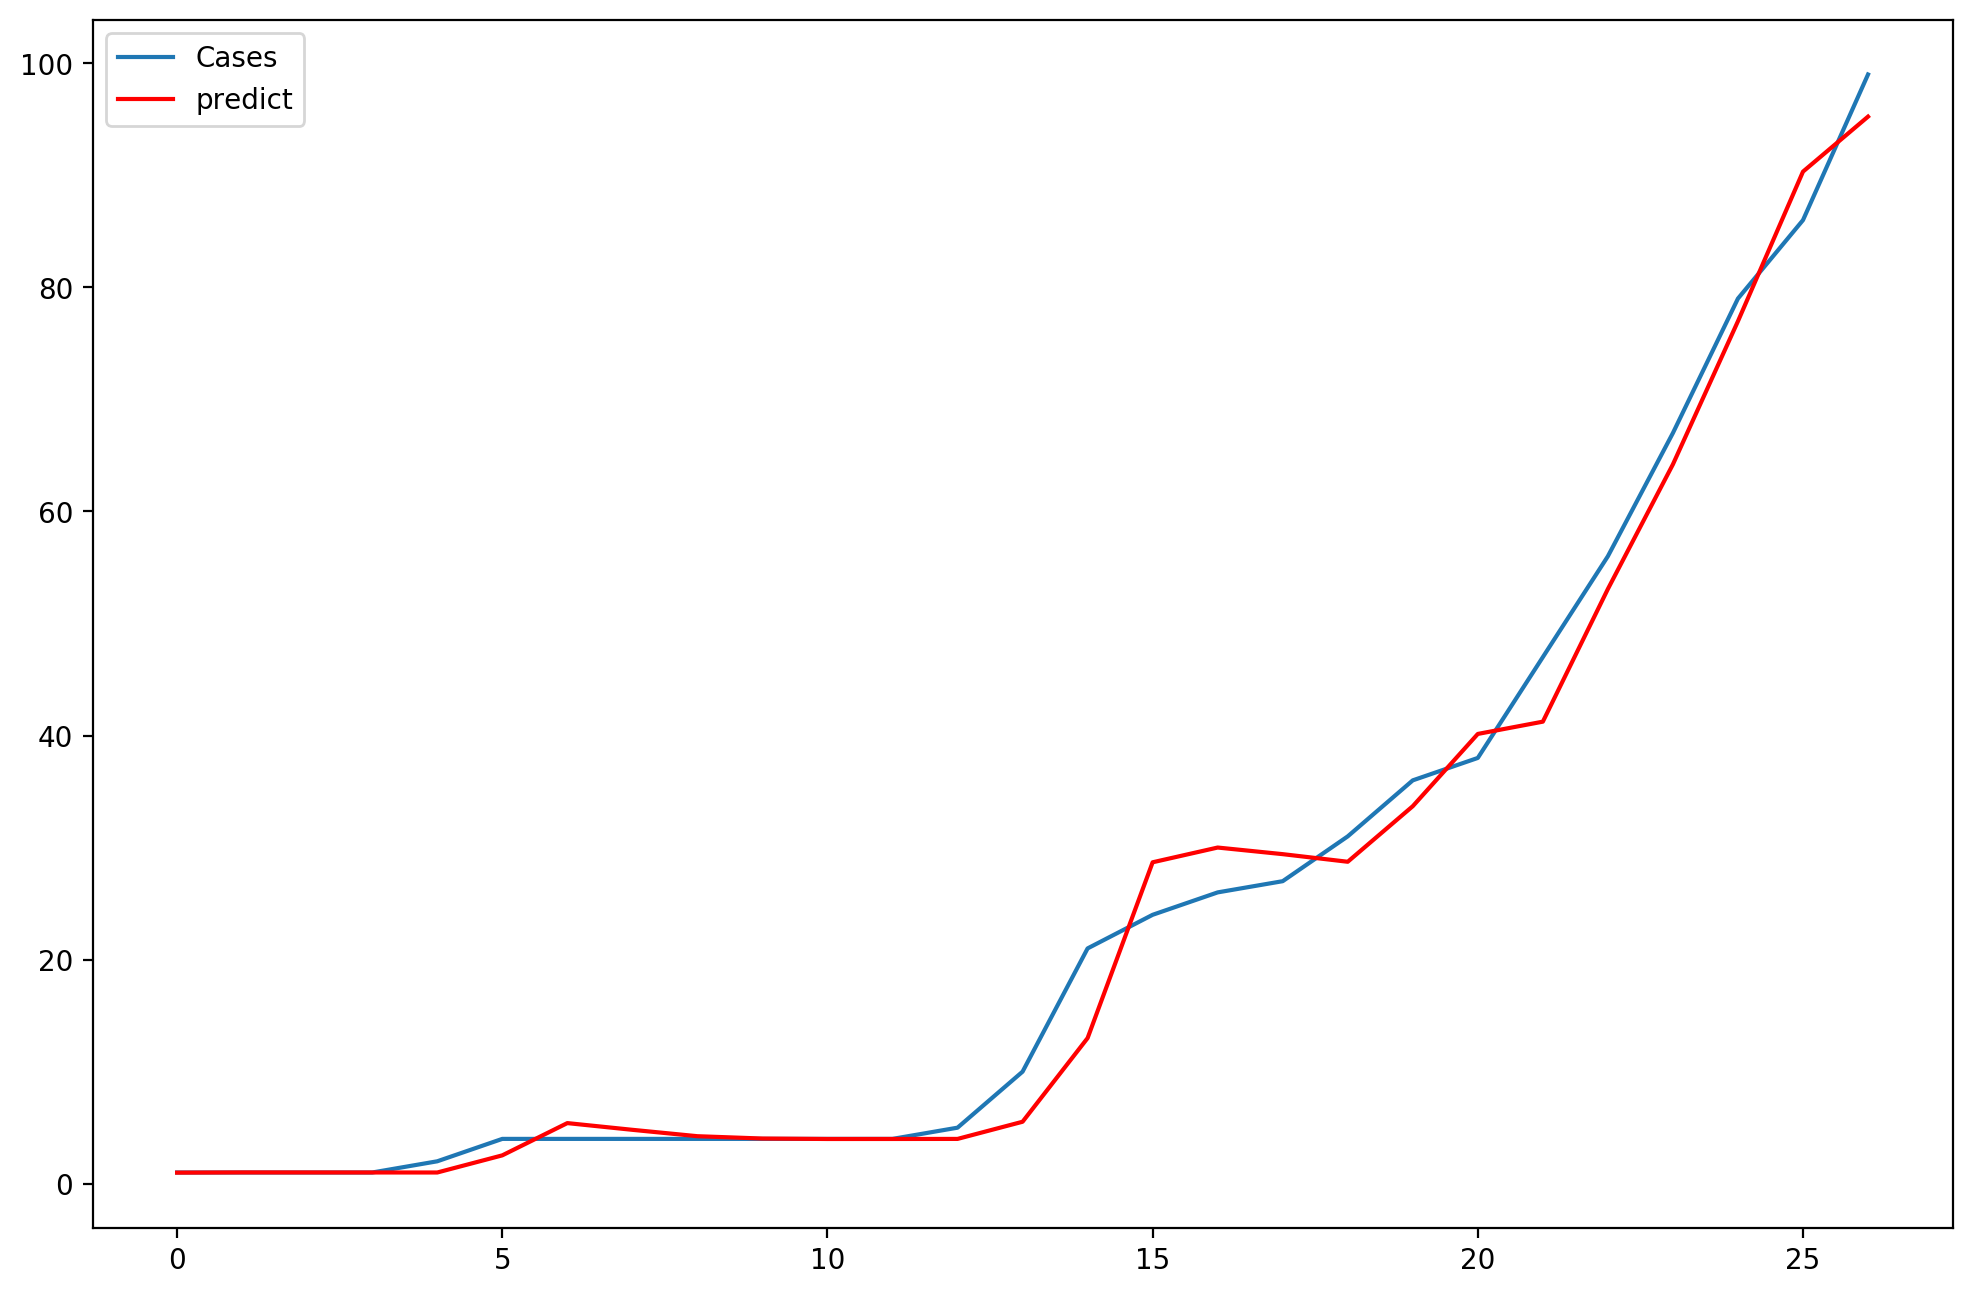

Les prévisions pour les 5 prochains jours sont:
27    109.798453
28    120.973211
29    132.147968
30    143.322726
31    154.497483
Name: Exponential trend, dtype: float64 


In [35]:
value_poss=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
from sklearn.metrics import mean_squared_error
mse_list=[]
params=[]
for i in value_poss:
    for j in value_poss:
        fit3 = Holt(data_sn1, damped=True).fit(smoothing_level=i, smoothing_slope=j)
        fcast3 = fit3.forecast(5).rename("Additive damped trend")
        predicted=fit3.fittedvalues
        error = mean_squared_error(data_sn1, predicted)
        mse_list.append(error)
        params.append((i,j))
ind=mse_list.index(min(mse_list))
#print(mse_list[ind],params[ind])
print('Le MSE minimal est {0} et la valeur de alpha et beta correspondantes sont {1}'.format(mse_list[ind],params[ind]))

fit3 = Holt(data_sn1, damped=True).fit(smoothing_level=params[ind][0], smoothing_slope=params[ind][1])
#fcast3= fit3.forecast(5).rename("Exponential trend")
error = mean_squared_error(data_sn1, predicted)
print( 'Le MSE est {}'.format(error))

# Visualisation de la prévision
plt.figure(figsize=(12,8),dpi=200)
plt.plot(data_sn1, label="Cases") # la courbe des données réelles 
plt.plot(fit3.fittedvalues, label="predict",color='red')# la courbe des données prédites
plt.legend()
plt.show ()

fcast3 = fit3.forecast(5).rename("Exponential trend")
print( 'Les prévisions pour les 5 prochains jours sont:')
      
print('{} '.format(fcast3))

